In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

In [3]:
def plot_map(my_map, positions=[], observations=[], values=[]):
    # draw the grid frame
    n = len(my_map)
    m = len(my_map[0])
    fig,ax = plt.subplots(figsize=(6, 6))
    
    # draw the whole grid
    for x,row in enumerate(my_map):
        for y,element in enumerate(row):
            if type(element)==type(0) and element == -1:
                ax.add_patch(Rectangle((x,y),1,1,color='lightgray'))
                ax.text(x+0.4,y+0.4,str('X'),c='black',size='xx-large')
            elif type(element)==type('str'):
                if element == 'Rw':
                    ax.add_patch(Rectangle((x,y),1,1,color='red'))
                    if len(values) == 0:
                        ax.text(x+0.35,y+0.4,element,c='black',size='xx-large')
                else:
                    ax.add_patch(Rectangle((x,y),1,1,color='lime'))
                    if len(values) == 0:
                        ax.text(x+0.35,y+0.4,element,c='black',size='xx-large')                   
    
    # if need rewards
    if len(values) > 0:
        for x,row in enumerate(my_map):
            for y,element in enumerate(row):
                if type(element)==type(0) and element == -1:
                    pass
                else:
                    ax.text(x+0.15,y+0.4,'{:.2f}'.format(values[x][y]),c='black',size='xx-large')
    else:
        # draw arrows of start
        if len(positions) > 0:
            ax.add_patch(Circle((positions[0][0]+0.5, positions[0][1]+0.5), 0.05, color='blue'))
            ax.text(positions[0][0]+0.05, positions[0][1]+0.2,'0',c='black',size='small') 
            if len(observations) > 0:
                ax.text(positions[0][0]+0.05, positions[0][1]+0.7, str(observations[0]),c='gray',size='small') 

        # draw all the movements
        max_num = len(positions)
        for num, pos in enumerate(positions[1:]):
            ax.add_patch(Circle((pos[0]+0.5, pos[1]+0.5), 0.05+0.15*(num+1)/max_num, color='blue'))
            ax.text(pos[0]+0.05+0.9*(num+1)/max_num, pos[1]+0.2, str(num+1), c='black', size='small') 
            if len(observations) == max_num:
                ax.text(pos[0]+0.05+0.9*(num+1)/max_num, pos[1]+0.7, str(observations[num+1]),c='gray',size='small') 
    
    # some configs
    plt.xticks(np.arange(n+1))
    plt.yticks(np.arange(m+1))

    ax.set_xticklabels([str(x) for x in np.arange(n+1)])
    ax.set_yticklabels([str(y) for y in np.arange(m+1)])
    
    plt.grid()
    plt.show()

In [4]:
moves_map = {0:[0,0], 1:[-1,0], 2:[0,1], 3:[1,0], 4:[0,-1]}
def move_one_step(my_map, pos, move, pe, n, m):
    # if already stop/ never
    #if type(my_map[pos[0]][pos[1]]) == type('str'):
    #    return pos
    
    # else choose the random action
    actions = [(1-pe)/(len(moves_map)-1)] * len(moves_map)
    actions[move] = pe
    action = np.argmax(np.random.multinomial(1, actions))
    movement = moves_map[action]
    # next pois
    next_pos =[pos[0]+movement[0], pos[1]+movement[1]]
    
    # if not valid: out the map
    if next_pos[0] < 0 or next_pos[0] >= n:
        return pos
    if next_pos[1] < 0 or next_pos[1] >= m:
        return pos
    
    # else if target is obstacle
    if type(my_map[next_pos[0]][next_pos[1]]) == type(0) and my_map[next_pos[0]][next_pos[1]] == -1:
        return pos
    
    return next_pos

def move(my_map, start, moves, pe):
    n = len(my_map)
    m = len(my_map[0])
    
    # find Rs, Rd
    for i in range(n):
        for j in range(m):
            if my_map[i][j] == 'Rs':
                rs_pos = [i,j]
            if my_map[i][j] == 'Rd':
                rd_pos = [i,j]
    
    # start and obs
    positions = [start]
    pos = start
    d_s = ((rs_pos[0]-pos[0])**2+(rs_pos[1]-pos[1])**2)**0.5
    d_d = ((rd_pos[0]-pos[0])**2+(rd_pos[1]-pos[1])**2)**0.5
    h = 2/(d_s**(-1)+d_d**(-1))
    p = 1-(np.ceil(h) - h)
    if np.random.rand() <= p:
        o = np.ceil(h)
    else:
        o = np.floor(h)
    observations = [int(o)]
    
    # move
    for move in moves:
        pos = move_one_step(my_map, pos, move, pe, n, m)
        positions.append(pos)
        
        d_s = ((rs_pos[0]-pos[0])**2+(rs_pos[1]-pos[1])**2)**0.5
        d_d = ((rd_pos[0]-pos[0])**2+(rd_pos[1]-pos[1])**2)**0.5
        h = 2/((d_s+0.001)**(-1)+(d_d+0.0001)**(-1))
        p = 1-(np.ceil(h) - h)
        if np.random.rand() <= p:
            o = np.ceil(h)
        else:
            o = np.floor(h)
        observations.append(int(o))
    
    return positions, observations

In [29]:
moves_map = {0:[0,0], 1:[-1,0], 2:[0,1], 3:[1,0], 4:[0,-1]}
def getValues(x, y, action, discount, my_map, rewards_map, values_old, n, m):
    # calculate the probabilities
    actions = [(1-pe)/(len(moves_map)-1)] * len(moves_map)
    actions[action] = pe

    value = 0
    # for each possible action
    for i in range(len(actions)):
        movement = moves_map[i]
    
        # next pos
        next_x = x + movement[0]
        next_y = y + movement[1]

        # if not valid: out the map
        if (next_x < 0 or next_x >= n) or (next_y < 0 or next_y >= m):
            next_x = x
            next_y = y
        # else if target is obstacle
        elif type(my_map[next_x][next_y]) == type(0) and my_map[next_x][next_y] == -1:
            next_x = x
            next_y = y
        
        # next value
        value = value + discount*actions[i]*values_old[next_x][next_y]
        
    return value + rewards_map[my_map[x][y]]


def VI(my_map, pe, discount, horizon, rewards_map, default=0):
    # prepare the vlaues
    n = len(my_map)
    m = len(my_map[0])

    values = [[0]*m for _ in range(n)]
    values_old = [[10]*m for _ in range(n)]
    
    # set rewards map
    rewards_map.setdefault(0, default)
    
    # ite = 0
    ite = 0
    while np.mean(np.abs(np.array(values) - np.array(values_old))) >= 1e-4 and ite < horizon:
        values_old = copy.deepcopy(values)
        # for every state
        for x,row in enumerate(my_map):
            for y,element in enumerate(row):
                if type(element)==type(0) and element == -1:
                    pass
                else:
                    tmp_values = [0] * len(moves_map)
                    # for each action, get its next value
                    for i, action in enumerate(range(len(moves_map))): 
                        tmp_values[i] = getValues(x, y, action, discount, my_map, rewards_map, values_old, n, m)
                    # assign
                    values[x][y] = max(tmp_values)  
        ite+=1
    return values

def getActions(my_map, pe, discount, horizon, rewards_map, values, default=0):
    # prepare the vlaues
    n = len(my_map)
    m = len(my_map[0])

    actions = [[-1]*m for _ in range(n)]
    
    # set rewards map
    rewards_map.setdefault(0, default)

    # for every state
    for x,row in enumerate(my_map):
        for y,element in enumerate(row):
            if type(element)==type(0) and element == -1:
                pass
            else:
                tmp_values = [0] * len(moves_map)
                # for each action, get its next value
                for i, action in enumerate(range(len(moves_map))): 
                    tmp_values[i] = getValues(x, y, action, discount, my_map, rewards_map, values, n, m)
                # assign
                actions[x][y] = np.argmax(tmp_values)  
    return actions

In [67]:
my_map = [[0]*5 for _ in range(5)]
my_map[2][0] = 'Rs'
my_map[2][2] = 'Rd'
my_map[1][1] = -1
my_map[2][1] = -1
my_map[1][3] = -1
my_map[2][3] = -1
my_map[4][0] = 'Rw'
my_map[4][1] = 'Rw'
my_map[4][2] = 'Rw'
my_map[4][3] = 'Rw'
my_map[4][4] = 'Rw'

In [68]:
pe = 1.0
discount = 0.9
horizon = np.inf
rewards_map = {'Rd' : 10, 'Rs': 10, 'Rw': -1}
default = 0

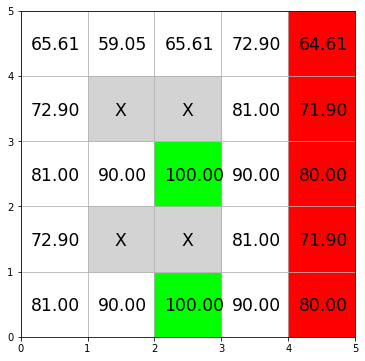

In [69]:
values = VI(my_map, pe, discount, horizon, rewards_map, default=0)
plot_map(my_map, p, o, values)

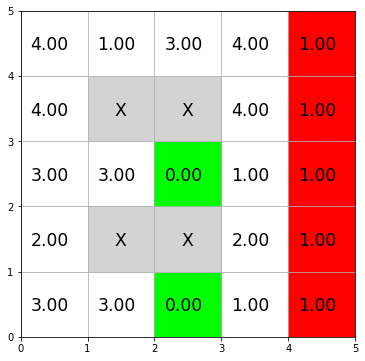

In [70]:
actions = getActions(my_map, pe, discount, horizon, rewards_map, values, default)
plot_map(my_map, p, o, actions)

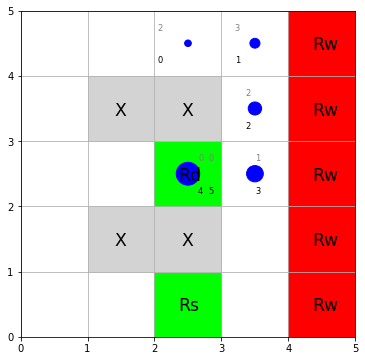

In [71]:
start = [2,4]
moves = [3,4,4,1,2]
p, o = move(my_map, start, moves, pe)
plot_map(my_map, p, o)